In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 读取数据
data = pd.read_csv('../fund_flow_simulated.csv')

# 转换日期类型
data["date"] = pd.to_datetime(data["date"])

# 添加节假日特征 (假设从 API 获取并已经保存)
# 示例代码：
# holidays = api.get_holidays(data["date"])
# data["is_holiday"] = data["date"].isin(holidays)
# 此处用简单规则代替：周末为节假日
data["is_holiday"] = data["date"].dt.weekday >= 5

# 添加日期特征
data["month"] = data["date"].dt.month
data["day_of_week"] = data["date"].dt.weekday
data["day_of_month"] = data["date"].dt.day

# 去掉无关列
data = data.drop(columns=["in_orig", "out_orig", "date", "clus"])

# 分离特征与目标
target_in = data["in"]
target_out = data["out"]
features = data.drop(columns=["in", "out"])

# 拆分训练集和测试集
X_train, X_test, y_train_in, y_test_in = train_test_split(features, target_in, test_size=0.2, random_state=42)
X_train, X_test, y_train_out, y_test_out = train_test_split(features, target_out, test_size=0.2, random_state=42)

# 建立模型
model_in = RandomForestRegressor(random_state=42)
model_out = RandomForestRegressor(random_state=42)

# 训练模型
model_in.fit(X_train, y_train_in)
model_out.fit(X_train, y_train_out)

# 预测
pred_in = model_in.predict(X_test)
pred_out = model_out.predict(X_test)

# 评估
mae_in = mean_absolute_error(y_test_in, pred_in)
mae_out = mean_absolute_error(y_test_out, pred_out)

print(f"MAE for 'in': {mae_in}")
print(f"MAE for 'out': {mae_out}")


MAE for 'in': 518773957.20801216
MAE for 'out': 511669628.0809806


In预测MSE: 5.891609421109334e+17
Out预测MSE: 5.4324144724690656e+17


C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pyl

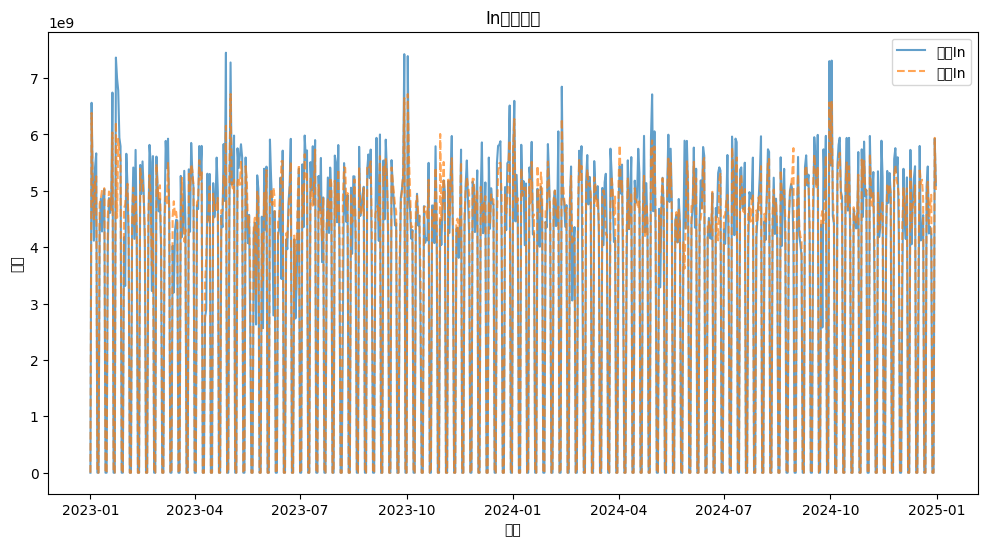

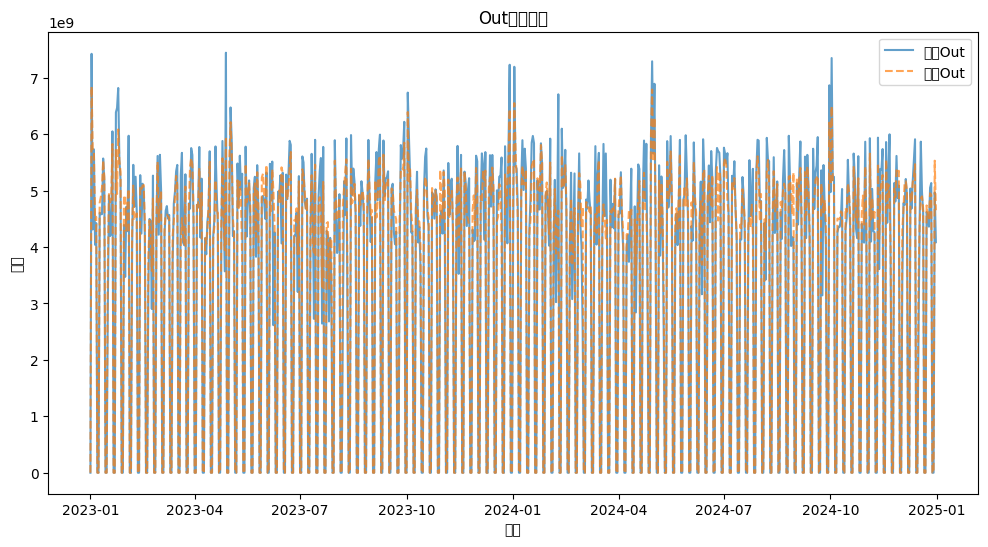

预测结果已保存到 'GBDT_prediction_results.csv'


In [3]:
# -*- coding: utf-8 -*-
"""
基金申赎预测代码
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#%% 数据加载与准备

# 加载数据
raw_data = pd.read_csv('../fund_flow_simulated.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'])

# 定义预测列
prediction_columns = ['in', 'out']

#%% 添加日期相关特征

raw_data['day_of_week'] = raw_data['date'].dt.dayofweek
raw_data['month'] = raw_data['date'].dt.month
raw_data['day'] = raw_data['date'].dt.day
raw_data['is_weekend'] = raw_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

#%% 添加节假日特征（示例，需根据API或现有数据实现）
holidays = ['2023-01-01', '2023-01-02']  # 示例节假日，请替换为你的实际数据
raw_data['is_holiday'] = raw_data['date'].astype(str).isin(holidays).astype(int)

#%% 数据标准化与模型输入准备

feature_columns = ['day_of_week', 'month', 'day', 'is_weekend', 'is_holiday']
X = raw_data[feature_columns]
y_in = raw_data['in']
y_out = raw_data['out']

# 数据划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_in_train, y_in_test = train_test_split(X, y_in, test_size=0.2, random_state=42)
X_train, X_test, y_out_train, y_out_test = train_test_split(X, y_out, test_size=0.2, random_state=42)

#%% 模型训练与预测

from sklearn.ensemble import RandomForestRegressor

# 分别训练两个模型
model_in = RandomForestRegressor(n_estimators=100, random_state=42)
model_out = RandomForestRegressor(n_estimators=100, random_state=42)

model_in.fit(X_train, y_in_train)
model_out.fit(X_train, y_out_train)

# 预测
y_in_pred = model_in.predict(X_test)
y_out_pred = model_out.predict(X_test)

#%% 结果评估

from sklearn.metrics import mean_squared_error

mse_in = mean_squared_error(y_in_test, y_in_pred)
mse_out = mean_squared_error(y_out_test, y_out_pred)

print(f"In预测MSE: {mse_in}")
print(f"Out预测MSE: {mse_out}")

#%% 合并结果与可视化

raw_data['in_pred'] = model_in.predict(X)
raw_data['out_pred'] = model_out.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(raw_data['date'], raw_data['in'], label='实际In', alpha=0.7)
plt.plot(raw_data['date'], raw_data['in_pred'], label='预测In', linestyle='--', alpha=0.7)
plt.legend()
plt.title('In预测结果')
plt.xlabel('日期')
plt.ylabel('金额')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(raw_data['date'], raw_data['out'], label='实际Out', alpha=0.7)
plt.plot(raw_data['date'], raw_data['out_pred'], label='预测Out', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Out预测结果')
plt.xlabel('日期')
plt.ylabel('金额')
plt.show()

#%% 保存预测结果

result_columns = ['date', 'in', 'out', 'in_pred', 'out_pred']
raw_data[result_columns].to_csv('GBDT_prediction_results.csv', index=False, encoding='utf-8')

print("预测结果已保存到 'GBDT_prediction_results.csv'")



In [2]:
import pandas as pd
import numpy as np
import datetime

# 读取数据
data = pd.read_csv('../fund_flow_simulated.csv')  # 请替换为你的数据路径

# 确保日期列格式一致
data['date'] = pd.to_datetime(data['date'])
data = data[['date', 'clus', 'in', 'out']]

# 设置日期范围
start_date = data['date'].min()
end_date = data['date'].max()
date_range = pd.date_range(start=start_date, end=end_date)

# 获取所有基金ID
funds = data['clus'].unique()

# 创建一个包含所有基金ID和日期的DataFrame
result_df = pd.DataFrame([(fund, date) for fund in funds for date in date_range], columns=['clus', 'date'])

# 合并数据，确保每个基金ID和日期都有对应的in和out数据
merged_data = pd.merge(result_df, data, on=['clus', 'date'], how='left')

# 填充缺失的'in'和'out'列（假设缺失值应该填充为0）
merged_data['in'] = merged_data['in'].fillna(0)
merged_data['out'] = merged_data['out'].fillna(0)

# 获取训练集和测试集的日期范围
TRN_N = 21  # 训练集长度
TST_N = 14  # 测试集长度

TRN_END = end_date - datetime.timedelta(days=(TST_N*3))
TRN_STA = TRN_END - datetime.timedelta(days=(TRN_N - 1))
TST_STA = TRN_END + datetime.timedelta(days=(1))
TST_END = TRN_END + datetime.timedelta(days=(TST_N))

# 筛选出训练集和测试集的数据
train_data = merged_data[(merged_data['date'] >= TRN_STA) & (merged_data['date'] <= TRN_END)]
test_data = merged_data[(merged_data['date'] >= TST_STA) & (merged_data['date'] <= TST_END)]

# 创建日期列
test_date_zip = zip([str(TRN_STA.date())], [str(TRN_END.date())], [str(TST_STA.date())], [str(TST_END.date())])

# 按照日期和基金ID重新组织数据
test_data = test_data.loc[:, ['clus', 'date', 'in', 'out']]

# 将数据按照基金ID和日期进行透视
pivot_data_in = test_data.pivot(index='clus', columns='date', values='in')
pivot_data_out = test_data.pivot(index='clus', columns='date', values='out')

# 合并in和out数据
final_data = pd.concat([pivot_data_in, pivot_data_out], axis=1, keys=['in', 'out'])

# 添加训练集和测试集的日期范围
final_data['TRN_STA'] = str(TRN_STA.date())
final_data['TRN_END'] = str(TRN_END.date())
final_data['TST_STA'] = str(TST_STA.date())
final_data['TST_END'] = str(TST_END.date())

# 保存结果为CSV文件
final_data.to_csv('TEST_SELLS.csv', index=False)

print("数据已生成并保存为 TEST_SELLS.csv")

数据已生成并保存为 TEST_SELLS.csv


In [3]:
final_data

in                                                    \
date    2024-11-20    2024-11-21    2024-11-22 2024-11-23 2024-11-24   
clus                                                                   
clus  4.787729e+09  5.315691e+09  4.942935e+09        0.0        0.0   

                                                                            \
date    2024-11-25    2024-11-26    2024-11-27    2024-11-28    2024-11-29   
clus                                                                         
clus  5.564771e+09  5.757031e+09  5.335187e+09  5.595627e+09  4.240418e+09   

      ...           out                                                    \
date  ...    2024-11-28    2024-11-29 2024-11-30 2024-12-01    2024-12-02   
clus  ...                                                                   
clus  ...  4.871167e+09  5.088978e+09        0.0        0.0  3.416154e+09   

                       TRN_STA     TRN_END     TST_STA     TST_END  
date    2024-12-03         NaT         NaT         NaT         NaT  
clus                                                                
clus  4.777116e+09  2024-10-30  2024-11-19  2024-11-20  2024-12-03  

[1 rows x 32 columns]

In [28]:
import pandas as pd
import numpy as np

# 读取数据
TEST = pd.read_csv('TEST_SELLS.csv')

# 初始化相关性数组
Cor_array = []
for ind, value in TEST.iterrows():
    # 提取列 1 到 21 的数据
    tt2 = value.iloc[1:22].transpose()  # 取列索引 1 到 21
    tt3 = np.asarray(tt2, dtype=np.float32).reshape([7, 3], order='F')  # 转为 7x3 的矩阵
    tt5 = np.corrcoef(tt3, rowvar=0)  # 按列计算相关性
    tt6 = tt5[np.triu_indices(3, k=1)]  # 提取上三角相关性
    Cor_array.append(tt6)

# 创建相关性 DataFrame
Cor_columns = [(lambda x: ('Cor' + str(x).zfill(2)))(x) for x in range(3)]
Cor_columns_in = ['Cor00', 'Cor01', 'Cor04']
Cor_array_pd = pd.DataFrame(Cor_array, columns=Cor_columns_in)

# 将相关性数据拼接到原始数据
TEST = pd.concat([TEST, Cor_array_pd], axis=1)

# 计算平均相关性
TEST['Cor_mean'] = TEST[['Cor00', 'Cor01', 'Cor04']].mean(axis=1)

# 按相关性排序
TEST_cor = TEST.sort_values(by=['Cor_mean', 'Cor04'], ascending=False)

# 筛选满足条件的数据
HIGH_LIMIT = 0.7
CRITERIA = 0.75
TEST_cor_candidate = TEST_cor[TEST_cor['Cor_mean'] > CRITERIA]
TEST_cor_candidate['Cor_min'] = TEST_cor_candidate[['Cor_mean', 'Cor04']].min(axis=1)
TEST_cor_candidate['credit'] = (TEST_cor_candidate['Cor_min'] - CRITERIA) * HIGH_LIMIT / (1.0 - CRITERIA)
TEST_cor_candidate = TEST_cor_candidate[TEST_cor_candidate['credit'] > 0].sort_values(by=['credit'], ascending=False)
TEST_cor_candidate.index = np.arange(len(TEST_cor_candidate))

# 计算每周平均值和增长率
average_list = []
increase_list1 = []
increase_list2 = []

for ind, value in TEST_cor_candidate.iterrows():
    w1 = value.iloc[1:8].values  # 第 1 到 7 天
    w2 = value.iloc[8:15].values  # 第 8 到 14 天
    w3 = value.iloc[15:22].values  # 第 15 到 21 天
    w_average = (w1 + w2 + w3) / 3.0
    average_list.append(w_average)
    increase_list1.append(0.62 * (w3.mean() - w2.mean()) + 0.38 * (w2.mean() - w1.mean()))
    increase_list2.append(0.62 * (np.median(w3) - np.median(w2)) + 0.38 * (np.median(w2) - np.median(w1)))

# 转为 DataFrame
average_list_pd = pd.DataFrame(average_list, columns=np.arange(7))
increase_list1_pd = pd.DataFrame(increase_list1, columns=['increase1'])
increase_list2_pd = pd.DataFrame(increase_list2, columns=['increase2'])

# 拼接到结果中
TEST_cor_candidate = pd.concat([TEST_cor_candidate, average_list_pd, increase_list1_pd, increase_list2_pd], axis=1)

# 增长率筛选
TEST_cor_candidate['7mean'] = TEST_cor_candidate.iloc[:, 1:8].mean(axis=1)
TEST_cor_candidate = TEST_cor_candidate[np.abs(TEST_cor_candidate['increase1'] / TEST_cor_candidate['7mean']) < 0.25]
TEST_cor_candidate = TEST_cor_candidate[np.abs(TEST_cor_candidate['increase2'] / TEST_cor_candidate['7mean']) < 0.25]
TEST_cor_candidate['increase'] = (0.5 * TEST_cor_candidate['increase2'] + 0.5 * TEST_cor_candidate['increase1']) * 1.0

# 调整结果值
TEST_cor_candidate[[f'{i:02d}' for i in range(1, 8)]] = TEST_cor_candidate[np.arange(7)].sub(
    -0.9 * TEST_cor_candidate['increase'], axis=0
)
TEST_cor_candidate[[f'{i:02d}' for i in range(8, 15)]] = TEST_cor_candidate[np.arange(7)].sub(
    -1.7 * TEST_cor_candidate['increase'], axis=0
)

# 筛选最终列
colo_list = ['SHOP_ID'] + [f'{i:02d}' for i in range(1, 15)] + ['credit']
TEST_cor_candidate = TEST_cor_candidate[colo_list]

# 保存结果
TEST_cor_candidate.to_csv('cor_model.csv', index=False)
print("相关性模型处理完成，结果已保存为 cor_model.csv")


<string>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


ValueError: could not convert string to float: '2024-11-21 00:00:00'

In [4]:
import pandas as pd
import numpy as np
import datetime

# 1. 创建模拟的 `user_pay_new.csv` 数据
np.random.seed(42)  # 保持随机性一致
num_shops = 50  # 模拟50个店铺
num_days = 500  # 模拟500天数据

shop_ids = np.arange(1, num_shops + 1)
dates = [str((datetime.datetime.strptime("2015-06-26", "%Y-%m-%d") + datetime.timedelta(days=i)).date()) for i in range(num_days)]

data = {
    "SHOP_ID": np.random.choice(shop_ids, num_shops * num_days),
    "DATE": np.random.choice(dates, num_shops * num_days),
    "Num_post": np.random.randint(1, 100, num_shops * num_days)
}
user_pay_new = pd.DataFrame(data)

# 保存模拟数据
user_pay_new.to_csv("user_pay_new.csv", index=False)

# 2. 创建模拟的 `FillOct.csv` 数据
fill_oct_data = {
    "SHOP_ID": np.random.choice(shop_ids, 100),
    "DATE": [str((datetime.datetime.strptime("2016-10-01", "%Y-%m-%d") + datetime.timedelta(days=i)).date()) for i in range(100)],
    "Num_post": np.random.randint(10, 50, 100)
}
fill_oct = pd.DataFrame(fill_oct_data)
fill_oct.to_csv("FillOct.csv", index=False)

# 3. 按照原始代码逻辑运行
PAYNW = pd.read_csv("user_pay_new.csv")

# 创建透视表
PAYNW_TAB = pd.pivot_table(PAYNW, values=["Num_post"], index=["SHOP_ID"], columns=["DATE"], aggfunc=np.sum)
PAYNW_TAB = PAYNW_TAB.fillna(0)  # 填充缺失值为0

PAYNW_TAB.columns = [str((datetime.datetime.strptime("2015-06-26", "%Y-%m-%d") + datetime.timedelta(days=x)).date()) for x in range(PAYNW_TAB.shape[1])]

# 提取 2016年10月09日至2016年10月31日的数据
PAYNW_TAB_OCT = PAYNW_TAB.loc[:, "2016-10-09":"2016-10-31"]
PAYNW_TAB_OCT.reset_index(level=0, inplace=True)

SHOP_MELT = pd.melt(PAYNW_TAB_OCT, id_vars=["SHOP_ID"], var_name="DATE", value_name="value")

# 替换小于等于10的值
SMALL_SHOP = SHOP_MELT[SHOP_MELT["value"] <= 1].copy()
SMALL_SHOP = SMALL_SHOP.sort_values(by=["SHOP_ID", "DATE"])

SMALL_count = SMALL_SHOP.groupby(by=["SHOP_ID"], as_index=False).count()
SMALL_count = SMALL_count[SMALL_count["DATE"] <= 2]
SMALL_SHOP = SMALL_SHOP[SMALL_SHOP["SHOP_ID"].isin(SMALL_count["SHOP_ID"])]
SMALL_SHOP.index = np.arange(len(SMALL_SHOP))

Substitude_list = []

# 遍历 SMALL_SHOP 行，生成替代值
for ind, value in SMALL_SHOP.iterrows():
    SHOP_ID = value["SHOP_ID"]
    DATE = value["DATE"]

    # 日期偏移量列表
    Day_shift_list = [-14, -7, 7, 14]
    Shop_sub_list = []

    for shift_ind in Day_shift_list:
        DATE_shift = str(
            (datetime.datetime.strptime(DATE, "%Y-%m-%d") + datetime.timedelta(days=shift_ind)).date()
        )
        try:
            # 获取 PAYNW_TAB 中 SHOP_ID 和 DATE_shift 的值
            value_append = PAYNW_TAB.loc[SHOP_ID, DATE_shift]
            Shop_sub_list.append(value_append)
        except KeyError:
            # 如果日期不存在或超出范围，追加 NaN
            Shop_sub_list.append(np.nan)

    # 检查当前行的替代值
    if all(pd.isna(Shop_sub_list)):
        print(f"Warning: All NaN for SHOP_ID={SHOP_ID} on DATE={DATE} with shifts {Day_shift_list}")

    Substitude_list.append(Shop_sub_list)

# 转换为 DataFrame，并检查其结构
Substitude_list = pd.DataFrame(Substitude_list)

# 如果 Substitude_list 为空，抛出错误信息
if not Substitude_list.empty:
    # 为 Substitude_list 添加列名
    Substitude_list.columns = [0, 1, 2, 3]

    # 合并替代值到 SMALL_SHOP，并计算最小值作为 Num_post
    SMALL_SHOP = pd.concat([SMALL_SHOP, Substitude_list], axis=1)
    SMALL_SHOP["Num_post"] = SMALL_SHOP[[0, 1, 2, 3]].min(axis=1)
    
    # 检查是否有 NaN 值
    if SMALL_SHOP["Num_post"].isna().any():
        print("Warning: NaN values found in Num_post after merging.")
    
    # 删除不需要的列
    SMALL_SHOP.drop([0, 1, 2, 3], axis=1, inplace=True)
else:
    # 处理没有替代值的情况
    SMALL_SHOP["Num_post"] = 0
    

# 更新 PAYNW_TAB
for ind, value in SMALL_SHOP.iterrows():
    SHOP_ID = value["SHOP_ID"]
    DATE = value["DATE"]
    PAYNW_TAB.loc[SHOP_ID, DATE] = value["Num_post"]


# 用 FillOct 数据进行替换
PAYNW_TAB_FIX = pd.read_csv("FillOct.csv")
PAYNW_TAB_FIX["DATE"] = [str(datetime.datetime.strptime(x, "%Y-%m-%d").date()) for x in PAYNW_TAB_FIX["DATE"]]

for ind, value in PAYNW_TAB_FIX.iterrows():
    SHOP_ID = value["SHOP_ID"]
    DATE = value["DATE"]
    PAYNW_TAB.loc[SHOP_ID, DATE] = value["Num_post"]

# 生成 TEST_SELLS 数据
TRN_N = 21
TST_N = 14

TRN_END = datetime.datetime.strptime("2016-10-31", "%Y-%m-%d")
TRN_STA = TRN_END - datetime.timedelta(days=(TRN_N - 1))
TST_STA = TRN_END + datetime.timedelta(days=1)
TST_END = TRN_END + datetime.timedelta(days=TST_N)

TEST = PAYNW_TAB.loc[:, str(TRN_STA.date()):str(TRN_END.date())]
TEST.reset_index(level=0, inplace=True)

TEST["TRN_STA"] = str(TRN_STA.date())
TEST["TRN_END"] = str(TRN_END.date())
TEST["TST_STA"] = str(TST_STA.date())
TEST["TST_END"] = str(TST_END.date())

TEST_TRN_C = ["SA" + str(x).zfill(2) for x in np.arange(TRN_N)]
TEST.columns = ["SHOP_ID"] + TEST_TRN_C + ["TRN_STA", "TRN_END", "TST_STA", "TST_END"]

# 保存最终数据
TEST.to_csv("OLD_TEST_SELLS.csv", index=False)

# 输出 TEST_SELLS 内容
print(TEST.head())


   SHOP_ID  SA00  SA01   SA02  SA03  SA04  SA05   SA06   SA07   SA08  ...  \
0        1  91.0  14.0  174.0   0.0   0.0   0.0   36.0   33.0   72.0  ...   
1        2  55.0  59.0    0.0   0.0  64.0  62.0   49.0  108.0   10.0  ...   
2        3  56.0   0.0   66.0   0.0  40.0   0.0  175.0   30.0  111.0  ...   
3        4   0.0  14.0   79.0   0.0   0.0  29.0   45.0   19.0   49.0  ...   
4        5  58.0  93.0   67.0   0.0  17.0   0.0   98.0   72.0    0.0  ...   

    SA15   SA16   SA17  SA18   SA19  SA20     TRN_STA     TRN_END     TST_STA  \
0   49.0  236.0   33.0  98.0  170.0   0.0  2016-10-11  2016-10-31  2016-11-01   
1  153.0  113.0    0.0   0.0   13.0   0.0  2016-10-11  2016-10-31  2016-11-01   
2   90.0   62.0   29.0   0.0    6.0  67.0  2016-10-11  2016-10-31  2016-11-01   
3  202.0    0.0   15.0   3.0   15.0  35.0  2016-10-11  2016-10-31  2016-11-01   
4  103.0   58.0  105.0   0.0   82.0   0.0  2016-10-11  2016-10-31  2016-11-01   

      TST_END  
0  2016-11-14  
1  2016-11-14  
2 

C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_32732\1977536586.py:36: FutureWarning: The provided callable <function sum at 0x0000029B397AEC00> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  PAYNW_TAB = pd.pivot_table(PAYNW, values=["Num_post"], index=["SHOP_ID"], columns=["DATE"], aggfunc=np.sum)


In [5]:
TEST

,SHOP_ID,SA00,SA01,SA02,SA03,SA04,SA05,SA06,SA07,SA08,...,SA15,SA16,SA17,SA18,SA19,SA20,TRN_STA,TRN_END,TST_STA,TST_END
0,1,91.0,14.0,174.0,0.0,0.0,0.0,36.0,33.0,72.0,...,49.0,236.0,33.0,98.0,170.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
1,2,55.0,59.0,0.0,0.0,64.0,62.0,49.0,108.0,10.0,...,153.0,113.0,0.0,0.0,13.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
2,3,56.0,0.0,66.0,0.0,40.0,0.0,175.0,30.0,111.0,...,90.0,62.0,29.0,0.0,6.0,67.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
3,4,0.0,14.0,79.0,0.0,0.0,29.0,45.0,19.0,49.0,...,202.0,0.0,15.0,3.0,15.0,35.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
4,5,58.0,93.0,67.0,0.0,17.0,0.0,98.0,72.0,0.0,...,103.0,58.0,105.0,0.0,82.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
5,6,169.0,57.0,11.0,96.0,101.0,73.0,0.0,0.0,72.0,...,0.0,0.0,62.0,48.0,0.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
6,7,0.0,68.0,24.0,0.0,0.0,3.0,0.0,20.0,0.0,...,0.0,0.0,95.0,139.0,0.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
7,8,60.0,34.0,0.0,84.0,39.0,30.0,0.0,0.0,27.0,...,0.0,150.0,0.0,97.0,0.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
8,9,56.0,0.0,0.0,0.0,0.0,34.0,0.0,183.0,170.0,...,80.0,43.0,0.0,0.0,18.0,0.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14
9,10,61.0,19.0,80.0,0.0,142.0,0.0,0.0,93.0,45.0,...,82.0,99.0,13.0,0.0,0.0,86.0,2016-10-11,2016-10-31,2016-11-01,2016-11-14


# 规则预测

In [6]:
import pandas as pd
import numpy as np
from multiprocessing import Pool

In [10]:
# 加载数据
raw_data = pd.read_csv('../fund_flow_simulated.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data[['date', 'in', 'out', 'clus']]

In [34]:
raw_data

,date,in,out,clus
0,2023-01-01,0.000000e+00,0.000000e+00,clus
1,2023-01-02,6.561810e+09,7.426071e+09,clus
2,2023-01-03,5.197317e+09,4.312037e+09,clus
3,2023-01-04,4.116167e+09,5.732352e+09,clus
4,2023-01-05,5.416145e+09,4.041169e+09,clus
...,...,...,...,...
726,2024-12-27,4.213754e+09,5.134624e+09,clus
727,2024-12-28,0.000000e+00,0.000000e+00,clus
728,2024-12-29,0.000000e+00,0.000000e+00,clus
729,2024-12-30,5.925854e+09,4.967091e+09,clus


In [11]:
raw_data.head(2)

,date,in,out,clus
0,2023-01-01,0.000000e+00,0.000000e+00,clus
1,2023-01-02,6.561810e+09,7.426071e+09,clus


d:\wuwenda\py3.12\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\wuwenda\py3.12\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


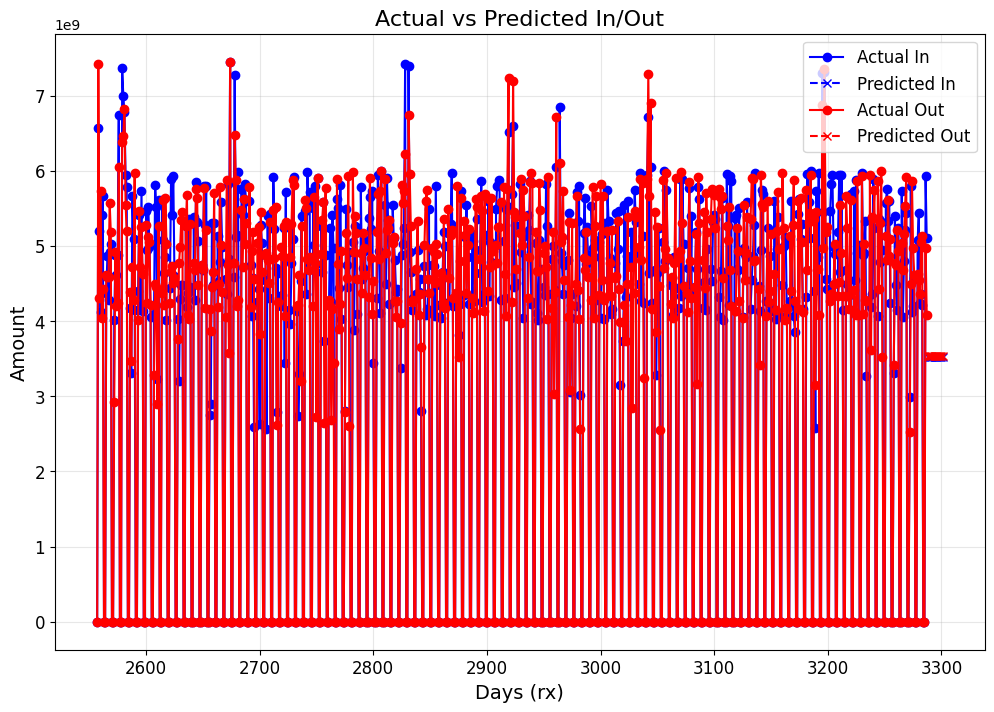

未来 14 天的预测结果：
          date  predicted_in  predicted_out
0   2025-01-01  3.516097e+09   3.530489e+09
1   2025-01-02  3.516108e+09   3.530555e+09
2   2025-01-03  3.516118e+09   3.530621e+09
3   2025-01-04  3.516129e+09   3.530686e+09
4   2025-01-05  3.516140e+09   3.530752e+09
5   2025-01-06  3.516150e+09   3.530817e+09
6   2025-01-07  3.516161e+09   3.530883e+09
7   2025-01-08  3.516172e+09   3.530949e+09
8   2025-01-09  3.516182e+09   3.531014e+09
9   2025-01-10  3.516193e+09   3.531080e+09
10  2025-01-11  3.516204e+09   3.531145e+09
11  2025-01-12  3.516214e+09   3.531211e+09
12  2025-01-13  3.516225e+09   3.531277e+09
13  2025-01-14  3.516235e+09   3.531342e+09


In [24]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# 假设原始数据
df = raw_data.copy()

# Step 1: 处理日期，设置基准日期
base_date = datetime.strptime("2016-01-01", "%Y-%m-%d")  # 基准日期
df["rx"] = (pd.to_datetime(df["date"]) - base_date).dt.days  # 转换为相对天数

# Step 2: 准备预测数据（分别对 `in` 和 `out` 进行处理）
X = df[["rx"]]  # 输入特征：相对天数

# ---- 对 `in` 进行预测 ----
y_in = df["in"]  # 目标变量：申购量
model_in = LinearRegression()
model_in.fit(X, y_in)

# ---- 对 `out` 进行预测 ----
y_out = df["out"]  # 目标变量：赎回量
model_out = LinearRegression()
model_out.fit(X, y_out)

# Step 3: 预测未来 14 天的申购量和赎回量
future_days = np.arange(df["rx"].max() + 1, df["rx"].max() + 15)  # 未来 14 天
future_rx = future_days.reshape(-1, 1)

# 预测申购量
predicted_in = model_in.predict(future_rx)

# 预测赎回量
predicted_out = model_out.predict(future_rx)

# 构建预测结果表
future_df = pd.DataFrame({
    "rx": future_days,
    "predicted_in": predicted_in,
    "predicted_out": predicted_out
})
future_df["date"] = (base_date + pd.to_timedelta(future_df["rx"], unit="days")).dt.strftime("%Y-%m-%d")

# 可视化：真实值 vs. 预测值
plt.figure(figsize=(12, 8))

# ---- 申购量对比 ----
# 历史数据
plt.plot(df["rx"], df["in"], label="Actual In", color="blue", marker="o")
# 预测数据
plt.plot(future_df["rx"], future_df["predicted_in"], label="Predicted In", linestyle="--", color="blue", marker="x")

# ---- 赎回量对比 ----
# 历史数据
plt.plot(df["rx"], df["out"], label="Actual Out", color="red", marker="o")
# 预测数据
plt.plot(future_df["rx"], future_df["predicted_out"], label="Predicted Out", linestyle="--", color="red", marker="x")

# 图表修饰
plt.title("Actual vs Predicted In/Out", fontsize=16)
plt.xlabel("Days (rx)", fontsize=14)
plt.ylabel("Amount", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 输出预测结果
print("未来 14 天的预测结果：")
print(future_df[["date", "predicted_in", "predicted_out"]])


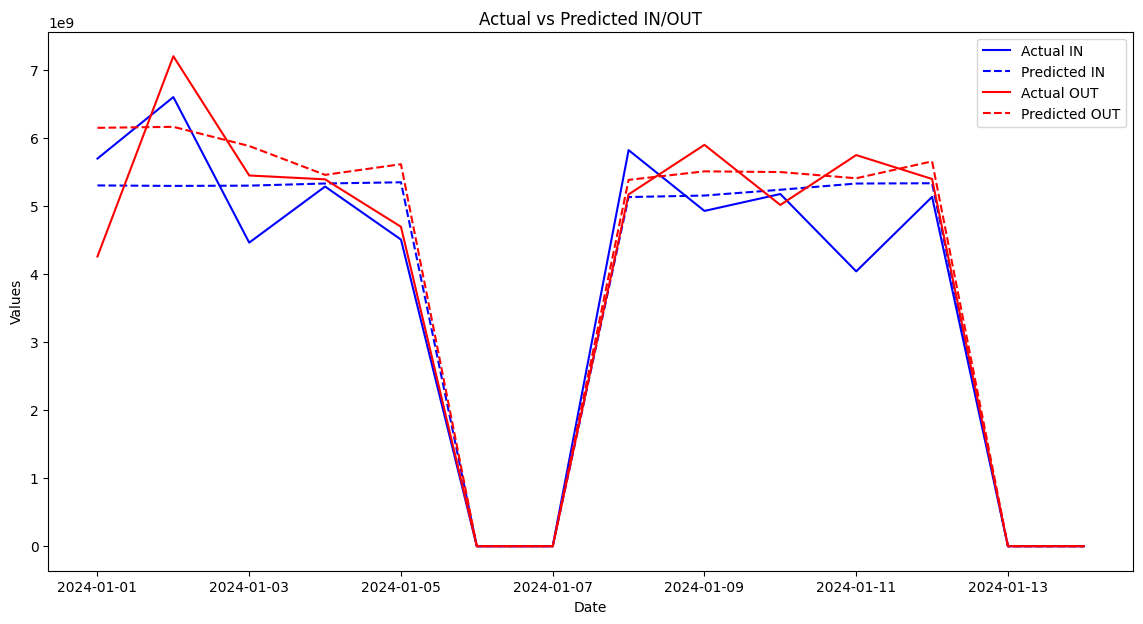

Mean Squared Error (IN): 4.7226264626956685e+17
Mean Squared Error (OUT): 7.308750435591867e+17


In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess data
data = raw_data.copy()
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear

# Add relative date (rx) as in the rule-based code
reference_date = pd.Timestamp('2023-01-01')
data['rx'] = (data['date'] - reference_date).dt.days

# Weather adjustment
# data['in_adjusted'] = data['in'] / (1 + 0.005 * data['weather'].fillna(0))
# data['out_adjusted'] = data['out'] / (1 + 0.005 * data['weather'].fillna(0))

# Add other engineered features (e.g., rolling averages, lags)
# data['in_rolling_mean_7'] = data['in_adjusted'].rolling(window=7).mean()
# data['out_rolling_mean_7'] = data['out_adjusted'].rolling(window=7).mean()
# data['in_lag_1'] = data['in_adjusted'].shift(1)
# data['out_lag_1'] = data['out_adjusted'].shift(1)

# User-defined prediction start date
prediction_start_date = pd.Timestamp('2024-01-01')  # Change this date as needed
periods = 14

# Filter data up to the prediction start date
train_data = data[data['date'] < prediction_start_date]
test_data = data[data['date'] >= prediction_start_date]

# Prepare training data
features = ['day_of_week', 'day_of_year', 'rx'] # , 'in_rolling_mean_7', 'in_lag_1', 'out_rolling_mean_7', 'out_lag_1']
X_train = train_data[features].dropna()
y_in_train = train_data.loc[X_train.index, 'in']
y_out_train = train_data.loc[X_train.index, 'out']

# Prepare test data for comparison
X_test = test_data[features].dropna()
y_in_test = test_data.loc[X_test.index, 'in']
y_out_test = test_data.loc[X_test.index, 'out']

# Train models
model_in = RandomForestRegressor(random_state=42)
model_out = RandomForestRegressor(random_state=42)
model_in.fit(X_train, y_in_train)
model_out.fit(X_train, y_out_train)

# Predict future values starting from the prediction start date
future_dates = pd.date_range(start=prediction_start_date, periods=periods)
future_data = pd.DataFrame({
    'date': future_dates,
    'day_of_week': future_dates.dayofweek,
    'day_of_year': future_dates.dayofyear,
    'rx': (future_dates - reference_date).days
})
prediction_end_date = prediction_start_date + pd.DateOffset(days=periods - 1)

# Add rolling mean and lag features for prediction
# last_7_days = train_data.iloc[-7:]
# future_data['in_rolling_mean_7'] = last_7_days['in_adjusted'].mean()
# future_data['out_rolling_mean_7'] = last_7_days['out_adjusted'].mean()
# future_data['in_lag_1'] = train_data.iloc[-1]['in_adjusted']
# future_data['out_lag_1'] = train_data.iloc[-1]['out_adjusted']

# Predict
future_data['in_pred'] = model_in.predict(future_data[features])
future_data['out_pred'] = model_out.predict(future_data[features])

# Combine predictions with actual values
predictions = future_data[['date', 'in_pred', 'out_pred']]
predictions = predictions.rename(columns={'in_pred': 'predicted_in', 'out_pred': 'predicted_out'})
actuals = data[['date', 'in', 'out']]
comparison = pd.concat([actuals.set_index('date'), predictions.set_index('date')], axis=1)

# Filter to show only the prediction period
comparison = comparison.loc[prediction_start_date:prediction_end_date]

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(comparison.index, comparison['in'], label='Actual IN', color='blue')
plt.plot(comparison.index, comparison['predicted_in'], label='Predicted IN', color='blue', linestyle='--')
plt.plot(comparison.index, comparison['out'], label='Actual OUT', color='red')
plt.plot(comparison.index, comparison['predicted_out'], label='Predicted OUT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted IN/OUT')
plt.legend()
plt.show()

# Calculate and print error metrics for the test set
if not X_test.empty:
    y_in_test_pred = model_in.predict(X_test)
    y_out_test_pred = model_out.predict(X_test)
    in_mse = mean_squared_error(y_in_test, y_in_test_pred)
    out_mse = mean_squared_error(y_out_test, y_out_test_pred)
    print(f'Mean Squared Error (IN): {in_mse}')
    print(f'Mean Squared Error (OUT): {out_mse}')


In [ ]:
# 读取用户支付数据，并计算日期相关的衍生字段
yhzf = pd.read_csv("user_pay.txt", names=["yh_id", "sj_id", "sj"], parse_dates=["sj"])  # 读取支付记录，包含用户ID、商家ID和时间
yhzf["rx"] = (yhzf["sj"] - pd.Timestamp("2016-11-01")).dt.days  # 计算每条记录相对于2016-11-01的天数差
yhzf["yr"] = (yhzf["rx"] + 904) % 7 + 1  # 计算周几（1-7表示周一到周日），偏移调整确保一致性

# 读取商家特征信息
sjtz = pd.read_csv(
    "shop_info.txt",
    names=["sj_id", "sm", "wzbh", "rjxf", "pf", "pls", "mddj", "yjplmc", "ejflmc", "sjflmc"],
    encoding="utf-8"
)  # 商家信息，包含商家ID、位置编号、评分等特征

# 读取天气数据，并计算日期相关的衍生字段
tq = pd.read_csv("weather.txt", names=["sm", "rq", "tq"], parse_dates=["rq"])  # 天气数据，包含位置、日期和天气指数
tq["rx"] = (tq["rq"] - pd.Timestamp("2016-11-01")).dt.days  # 计算相对于2016-11-01的天数差

# 聚合流量数据
xl = yhzf.groupby(["sj_id", "rx", "yr"]).size().reset_index(name="sjkll")  # 按商家ID、天数和周几统计流量

# 定义核心计算函数
def calculate_predictions(xl, sjtz, tq, qsrx, fw, fwa=None, r=0, s=0):
    """
    根据输入数据和参数计算预测值。
    - xl: 聚合的流量数据
    - sjtz: 商家特征数据
    - tq: 天气数据
    - qsrx: 起始天数
    - fw: 预测窗口范围
    - fwa: 加权窗口
    - r, s: 其他控制参数，表示是否执行特定调整逻辑
    """
    # 具体计算逻辑需要基于业务需求实现，与R代码的逻辑等价
    pass

# 定义分布式预测函数
def qdyc(a, xl, sjtz, tq):
    """
    对单个类别进行预测。
    - a: 类别编号
    - xl, sjtz, tq: 数据集
    """
    fw_map = {
        1: [-1, -21, -36, -42],  # 类别1的时间窗口
        2: [-1, -21, -29, -42],  # 类别2的时间窗口
        3: [-1, -21],  # 类别3的时间窗口
        4: [-1, -28],  # 类别4的时间窗口
        5: [-1, -7],  # 类别5的时间窗口
        6: [-1, -14],  # 类别6的时间窗口
        7: [-1, -21],  # 类别7的时间窗口
        8: [-1, -21, -36, -42]  # 类别8的时间窗口
    }
    weights = [0.30, 0.10, 0.10, 0.10, 0.07, 0.09, 0.11, 0.13]  # 每个类别的权重
    fw = fw_map[a]  # 获取类别对应的时间窗口
    weight = weights[a - 1]  # 获取类别对应的权重
    return weight * calculate_predictions(
        xl, sjtz, tq, 0, fw, fwa=fw, r=1 if a in [1, 2, 3, 4] else 0, s=1 if a in [5, 6, 7, 8] else 0
    )  # 按条件设置参数并调用计算函数

# 并行计算预测
with Pool(4) as pool:  # 使用多进程加速计算
    results = pool.starmap(qdyc, [(a, xl, sjtz, tq) for a in range(1, 9)])  # 对每个类别进行预测并收集结果

# 合并预测结果
yca = pd.DataFrame({"sj_id": np.repeat(sjtz["sj_id"].values, 14), "rx": np.tile(np.arange(14), len(sjtz))})  # 构建预测结果模板
yca["yc"] = sum(results)  # 汇总所有类别的预测结果

# 后处理与输出
yca = yca.merge(sjtz[["sj_id", "sm"]], on="sj_id", how="left")  # 合并商家信息
yca = yca.merge(tq[["rx", "sm", "tq"]], on=["rx", "sm"], how="left")  # 合并天气信息
yca["tq"].fillna(0, inplace=True)  # 填充天气数据中的空值
yca["yc"] = yca["yc"] * (1 + 0.005 * yca["tq"])  # 根据天气指数调整预测值
yca.loc[yca["rx"] == 10, "yc"] *= 1.1  # 对特定天数的预测值进行额外调整
yca["yc"] = yca["yc"].astype(int)  # 将预测值转换为整数
yca.sort_values(["sj_id", "rx"], inplace=True)  # 按商家ID和日期排序

# 导出结果
result = yca.pivot(index="sj_id", columns="rx", values="yc").reset_index()  # 将数据透视为以商家为索引的表格
result.columns = ["sj_id"] + [f"r{i}" for i in range(14)]  # 重命名列
result.to_csv("0.csv", index=False, header=False)  # 导出预测结果


In [ ]:
# 读取用户支付数据，并计算日期相关的衍生字段
yhzf = pd.read_csv("user_pay.txt", names=["yh_id", "sj_id", "sj"], parse_dates=["sj"])  # 读取支付记录，包含用户ID、商家ID和时间
yhzf["rx"] = (yhzf["sj"] - pd.Timestamp("2016-11-01")).dt.days  # 计算每条记录相对于2016-11-01的天数差
yhzf["yr"] = (yhzf["rx"] + 904) % 7 + 1  # 计算周几（1-7表示周一到周日），偏移调整确保一致性

# 读取商家特征信息
sjtz = pd.read_csv(
    "shop_info.txt",
    names=["sj_id", "sm", "wzbh", "rjxf", "pf", "pls", "mddj", "yjplmc", "ejflmc", "sjflmc"],
    encoding="utf-8"
)  # 商家信息，包含商家ID、位置编号、评分等特征

# 读取天气数据，并计算日期相关的衍生字段
tq = pd.read_csv("weather.txt", names=["sm", "rq", "tq"], parse_dates=["rq"])  # 天气数据，包含位置、日期和天气指数
tq["rx"] = (tq["rq"] - pd.Timestamp("2016-11-01")).dt.days  # 计算相对于2016-11-01的天数差

# 聚合流量数据
xl = yhzf.groupby(["sj_id", "rx", "yr"]).size().reset_index(name="sjkll")  # 按商家ID、天数和周几统计流量

# 定义核心计算函数
def calculate_predictions(xl, sjtz, tq, qsrx, fw, fwa=None, r=0, s=0):
    """
    根据输入数据和参数计算预测值。
    - xl: 聚合的流量数据
    - sjtz: 商家特征数据
    - tq: 天气数据
    - qsrx: 起始天数
    - fw: 预测窗口范围
    - fwa: 加权窗口
    - r, s: 其他控制参数，表示是否执行特定调整逻辑
    """
    # 具体计算逻辑需要基于业务需求实现，与R代码的逻辑等价
    pass

# 定义分布式预测函数
def qdyc(a, xl, sjtz, tq):
    """
    对单个类别进行预测。
    - a: 类别编号
    - xl, sjtz, tq: 数据集
    """
    fw_map = {
        1: [-1, -21, -36, -42],  # 类别1的时间窗口
        2: [-1, -21, -29, -42],  # 类别2的时间窗口
        3: [-1, -21],  # 类别3的时间窗口
        4: [-1, -28],  # 类别4的时间窗口
        5: [-1, -7],  # 类别5的时间窗口
        6: [-1, -14],  # 类别6的时间窗口
        7: [-1, -21],  # 类别7的时间窗口
        8: [-1, -21, -36, -42]  # 类别8的时间窗口
    }
    weights = [0.30, 0.10, 0.10, 0.10, 0.07, 0.09, 0.11, 0.13]  # 每个类别的权重
    fw = fw_map[a]  # 获取类别对应的时间窗口
    weight = weights[a - 1]  # 获取类别对应的权重
    return weight * calculate_predictions(
        xl, sjtz, tq, 0, fw, fwa=fw, r=1 if a in [1, 2, 3, 4] else 0, s=1 if a in [5, 6, 7, 8] else 0
    )  # 按条件设置参数并调用计算函数

# 并行计算预测
with Pool(4) as pool:  # 使用多进程加速计算
    results = pool.starmap(qdyc, [(a, xl, sjtz, tq) for a in range(1, 9)])  # 对每个类别进行预测并收集结果

# 合并预测结果
yca = pd.DataFrame({"sj_id": np.repeat(sjtz["sj_id"].values, 14), "rx": np.tile(np.arange(14), len(sjtz))})  # 构建预测结果模板
yca["yc"] = sum(results)  # 汇总所有类别的预测结果

# 后处理与输出
yca = yca.merge(sjtz[["sj_id", "sm"]], on="sj_id", how="left")  # 合并商家信息
yca = yca.merge(tq[["rx", "sm", "tq"]], on=["rx", "sm"], how="left")  # 合并天气信息
yca["tq"].fillna(0, inplace=True)  # 填充天气数据中的空值
yca["yc"] = yca["yc"] * (1 + 0.005 * yca["tq"])  # 根据天气指数调整预测值
yca.loc[yca["rx"] == 10, "yc"] *= 1.1  # 对特定天数的预测值进行额外调整
yca["yc"] = yca["yc"].astype(int)  # 将预测值转换为整数
yca.sort_values(["sj_id", "rx"], inplace=True)  # 按商家ID和日期排序

# 导出结果
result = yca.pivot(index="sj_id", columns="rx", values="yc").reset_index()  # 将数据透视为以商家为索引的表格
result.columns = ["sj_id"] + [f"r{i}" for i in range(14)]  # 重命名列
result.to_csv("0.csv", index=False, header=False)  # 导出预测结果
